<a href="https://colab.research.google.com/github/kimhwijin/korean_food_classifier/blob/master/korean_food_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unzip Dataset

In [1]:
import time

start = time.time()
!unzip -qq "drive/MyDrive/Datasets/kfood.zip"
end = time.time()
print((end-start) // 60, "분...")

4.0 분...


#Clone github

In [2]:
!git clone https://github.com/kimhwijin/korean_food_classifier.git

Cloning into 'korean_food_classifier'...
remote: Enumerating objects: 347, done.
remote: Counting objects: 100% (347/347), done.
remote: Compressing objects: 100% (242/242), done.
remote: Total 347 (delta 197), reused 228 (delta 101), pack-reused 0
Receiving objects: 100% (347/347), 11.21 MiB | 22.74 MiB/s, done.
Resolving deltas: 100% (197/197), done.


In [3]:
import sys
import os
sys.path.append(os.getcwd() + '/korean_food_classifier')

In [2]:
import kfood_dataset

BATCH_SIZE = 32
RANDOMIZE = True #random crop variable
EPOCHS = 50
paths = kfood_dataset.get_image_paths()

finding image paths...
shuffling...
paths ready!


# Imports

In [3]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Make Train, Valid, Test, Dataset

In [4]:
# train : 0.64, test : 0.2, valid : 0.16
train_paths_full, test_paths = train_test_split(paths, test_size=0.2)
train_paths, valid_paths = train_test_split(train_paths_full, test_size=0.125)

In [6]:
train_set = kfood_dataset.make_kfood_dataset(train_paths, n_parse_threads=tf.data.AUTOTUNE, batch_size=BATCH_SIZE, shuffle_buffer_size=len(train_paths) // BATCH_SIZE, randomize=RANDOMIZE)
valid_set = kfood_dataset.make_kfood_dataset(valid_paths, n_parse_threads=tf.data.AUTOTUNE, batch_size=BATCH_SIZE, shuffle_buffer_size=len(valid_paths) // BATCH_SIZE, randomize=RANDOMIZE)
test_set = kfood_dataset.make_kfood_dataset(test_paths, n_parse_threads=tf.data.AUTOTUNE, batch_size=4, randomize=False)

# Plot samples

2022-02-11 18:05:18.765748: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-11 18:05:18.768860: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


잔치국수 양념치킨 회무침 계란찜 

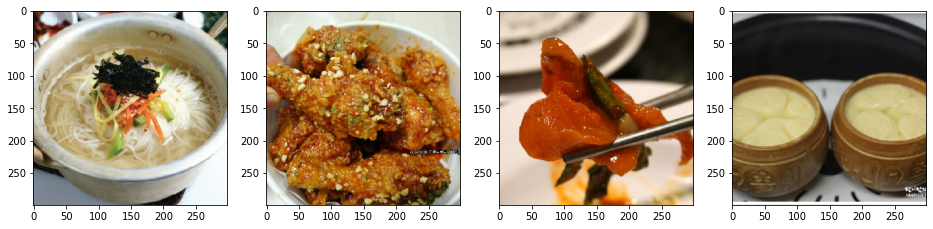

In [7]:
kfood_dataset.plot_dataset_image_4(test_set)

# Model Saver

In [8]:
class ModelSaver(keras.callbacks.Callback):
    def __init__(self, now, model_paths,**kwargs):
        self.now = now
        self.model_paths = model_paths
        self.loss = np.array([])
    
    def on_epoch_end(self, epoch, logs={}):

        fileformats = [self.now.year, self.now.month, self.now.day, self.now.hour, self.now.minute, epoch, logs['val_accuracy']]
        self.model.save(self.model_paths + "/{}-{}-{}_{}:{}_{}_{:.2f}%.hd5".format(*fileformats))
    
        self.loss = np.append(self.loss, logs["loss"])
        plt.plot(np.arange(1, epoch+2), self.loss)
        plt.axis([1, EPOCHS, 0, self.loss[0] * 1.2])
        plt.savefig(self.model_paths + "/val_loss.png", format="png", dpi=300)
        


# Model Train With Pretrained Model

In [9]:
base_model = keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False, weights='imagenet', input_shape=[299,299,3])
avg = keras.layers.GlobalAvgPool2D()(base_model.output)
output = keras.layers.Dense(150, activation='softmax')(avg)

model = keras.models.Model(inputs=[base_model.input], outputs=[output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

# BaseLayer Freeze

In [10]:
# freeze
for layer in base_model.layers:
    layer.trainable = False

# Compile and Train

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, nesterov=0.9, decay=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
history = model.fit(train_set, steps_per_epoch=len(paths[30000:])//batch_size,
          validation_data=valid_set, validation_steps=10000 // batch_size, 
          epochs=5)

Epoch 1/5
3765/3765 [==============================] - 789s 201ms/step - loss: 1.9645 - accuracy: 0.5206 - val_loss: 1.5937 - val_accuracy: 0.5800
Epoch 2/5
3765/3765 [==============================] - 751s 199ms/step - loss: 1.5099 - accuracy: 0.6019 - val_loss: 1.5502 - val_accuracy: 0.5931
Epoch 3/5
3765/3765 [==============================] - 753s 200ms/step - loss: 1.4439 - accuracy: 0.6198 - val_loss: 1.5046 - val_accuracy: 0.6044
Epoch 4/5
3765/3765 [==============================] - 750s 199ms/step - loss: 1.4117 - accuracy: 0.6307 - val_loss: 1.4977 - val_accuracy: 0.6137
Epoch 5/5
3765/3765 [==============================] - 754s 200ms/step - loss: 1.3901 - accuracy: 0.6347 - val_loss: 1.4925 - val_accuracy: 0.6098


In [ ]:
#save connacted pretrained and new model
now = datetime.datetime.now()
fileformats = [now.year, now.month, now.day, now.hour, now.minute]
model.save(model_paths + "stem_{}_{}_{}_{}_{}.hd5".format(*fileformats))

INFO:tensorflow:Assets written to: drive/MyDrive/Model/kfood/PretrainedInceptionResNetV2/stem_2022_1_31_9_40.hd5/assets


# Load Connected Weight Model

In [ ]:
model = keras.models.load_model("/content/drive/MyDrive/Model/kfood/PretrainedInceptionResNetV2/stem_2022_1_31_9_40.hd5")

# Check Weights With Evaluate

In [ ]:
model.evaluate(valid_set, steps=10000 // 32)

312/312 [==============================] - 64s 191ms/step - loss: 1.4889 - accuracy: 0.6132


[1.4888681173324585, 0.6131811141967773]

# Release Layers

In [ ]:
#release
for layer in model.layers[:-2]:
    layer.trainable = True

# Compile and Train

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True, decay=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
history = model.fit(train_set, steps_per_epoch=len(paths[30000:])//batch_size,
          validation_data=valid_set, validation_steps=10000 // batch_size, 
          epochs=40,
          callbacks=[ModelSaver(datetime.datetime.now(), model_paths.format(model_name))]
          )

Epoch 1/40
3765/3765 [==============================] - 2326s 606ms/step - loss: 0.7652 - accuracy: 0.7866 - val_loss: 0.6133 - val_accuracy: 0.8289
Epoch 2/40
3765/3765 [==============================] - 2285s 607ms/step - loss: 0.3556 - accuracy: 0.9014 - val_loss: 0.5375 - val_accuracy: 0.8478
Epoch 3/40
3765/3765 [==============================] - 2283s 606ms/step - loss: 0.2173 - accuracy: 0.9421 - val_loss: 0.5122 - val_accuracy: 0.8574
Epoch 4/40
3765/3765 [==============================] - 2294s 609ms/step - loss: 0.1462 - accuracy: 0.9643 - val_loss: 0.5131 - val_accuracy: 0.8607
Epoch 5/40
3765/3765 [==============================] - 2291s 609ms/step - loss: 0.1071 - accuracy: 0.9766 - val_loss: 0.5108 - val_accuracy: 0.8625
Epoch 6/40
3765/3765 [==============================] - 2284s 607ms/step - loss: 0.0840 - accuracy: 0.9833 - val_loss: 0.5136 - val_accuracy: 0.8622
Epoch 7/40
3765/3765 [==============================] - 2280s 606ms/step - loss: 0.0675 - accuracy: 0.9879

KeyboardInterrupt: ignored

# Custom Inception ResNet Model

In [10]:
from application.inception_resnet_v2 import InceptionResNetV2

inception = InceptionResNetV2()
inception.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
from application.inception_resnet_v2_se import InceptionResNetV2SEBlock

inception = InceptionResNetV2SEBlock()
inception.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

# Custom Model Compile

In [23]:
inception = keras.models.load_model("/content/drive/MyDrive/Model/kfood/InceptionResNetV2/2022_1_27_10_5_29.hd5")

In [16]:
inception.evaluate(valid_set, steps=len(valid_paths)//BATCH_SIZE)

752/752 [==============================] - 283s 356ms/step - loss: 1.3197 - accuracy: 0.6454


[1.319654941558838, 0.6454039216041565]

In [24]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True, decay=0.001)
inception.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Custom Model Train and Save

In [25]:
from datetime import datetime
model_paths = "drive/MyDrive/Model/kfood/{}/{}"
model_name = "InceptionResNetV2"
train_property = "SGD_Random"

model_saver = ModelSaver(datetime.now(), model_paths.format(model_name, train_property))

best_model_saver = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_paths.format(model_name, train_property) + "/best",
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
history = inception.fit(train_set, steps_per_epoch=len(train_paths)//BATCH_SIZE,
          validation_data=valid_set, validation_steps=len(valid_paths) // BATCH_SIZE,
          epochs=EPOCHS,
          callbacks=[model_saver, best_model_saver])

Epoch 1/40
3010/3010 [==============================] - ETA: 0s - loss: 0.8807 - accuracy: 0.7546INFO:tensorflow:Assets written to: drive/MyDrive/Model/kfood/InceptionResNetV2/SGD_Random/2022-2-10_4:25_0_0.78%.hd5/assets
INFO:tensorflow:Assets written to: drive/MyDrive/Model/kfood/InceptionResNetV2/SGD_Random/best/assets
3010/3010 [==============================] - 2064s 675ms/step - loss: 0.8807 - accuracy: 0.7546 - val_loss: 0.7982 - val_accuracy: 0.7798
Epoch 2/40
1675/3010 [===============>..............] - ETA: 12:27 - loss: 0.8358 - accuracy: 0.7650

In [ ]:
inception.evaluate(test_set, steps=len(test_paths))

In [ ]:
import json
json = json.dumps(history.history)
f = open(model_paths.format(model_name, train_property) + "/history.json","w")
f.write(json)
f.close()